In [1]:
# built-in
import sys
import os
import pickle
from pathlib import Path

# installed
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../")

In [4]:
# local
from utils import data_helper
from utils import preprocessing
from utils.models import RNN
from utils.data_helper import ClickbaitDataSet
from utils.data_helper import get_data_from_file
from utils.data_helper import building_vocab
from train_and_evaluate import get_loss_and_optimizer
from train_and_evaluate import train_model_for_one_epoch
from train_and_evaluate import evaluate_model
from utils.showing_results import ClickbaitClassifier

# Getting validation set

In [11]:
clickbait_yes_valid_path = Path('../', 'data', 'validation', 'clickbait_yes')
clickbait_no_valid_path = Path('../', 'data', 'validation', 'clickbait_no')

# uploading data
clickbait_yes_valid = get_data_from_file(clickbait_yes_valid_path)
clickbait_no_valid = get_data_from_file(clickbait_no_valid_path)
print('The length of clickbait_yes_data:', len(clickbait_yes_valid))
print('The length of clickbait_no_data:', len(clickbait_no_valid))
print()

# preprocessing data
preprocesser = preprocessing.Preprocess()
clickbait_yes_valid_preprocessed = preprocesser(clickbait_yes_valid)
clickbait_no_valid_preprocessed = preprocesser(clickbait_no_valid)

# joining data + creating X and y
X_valid = clickbait_yes_valid_preprocessed + clickbait_no_valid_preprocessed
y_clickbait_yes_valid_np = np.ones(shape=(len(clickbait_yes_valid_preprocessed), ))#.reshape(-1, 1)
y_clickbait_no_valid_np = np.zeros(shape=(len(clickbait_no_valid_preprocessed), ))#.reshape(-1, 1)
y_valid = np.concatenate((y_clickbait_yes_valid_np, y_clickbait_no_valid_np))

# checking whether everything is OK with X and y!
print(f'The length of X and y are the same: {len(X_valid) == len(y_valid)}')
print()
print(f"1's and 0's on the right places: {(y_valid[len(clickbait_yes_valid_preprocessed)-1] == 1) and (y_valid[len(clickbait_yes_valid_preprocessed)] == 0)}")
print()

The length of clickbait_yes_data: 1664
The length of clickbait_no_data: 1536

The length of X and y are the same: True

1's and 0's on the right places: True



# Upload vocab

In [20]:
with open('../data/vocab.pkl', 'rb') as f:  #rb - read binary 
    vocab = pickle.load(f)

# Collating batches

In [13]:
# transforms sentence with words into sentence with vocab-ids corresponding to these words
sentence_pipeline = lambda sentence: [vocab[token] if token in vocab else vocab["<unk>"] for token in sentence]

def collate_batch(batch):
    
    label_list, all_sentences_list, lengths = [], [], []
    
    for _sentence, _label, in batch: # a sample with its label from train_dataset
        label_list.append(_label)
        processed_sentence = torch.tensor(sentence_pipeline(_sentence), dtype=torch.int64)
        all_sentences_list.append(processed_sentence)
        lengths.append(processed_sentence.size(0))
        
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_sentences_list = nn.utils.rnn.pad_sequence(all_sentences_list, batch_first=True)
    
    return padded_sentences_list, label_list, lengths

# Import model with dropouts

In [5]:
model_with_dropouts = torch.load('model_with_dropouts')

In [6]:
type(model_with_dropouts)

utils.models.RNN

In [15]:
valid_dataset = ClickbaitDataSet(X_valid, y_valid)
batch_size = 32

valid_dl = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

# Evaluation

F1_score for test = 0.962


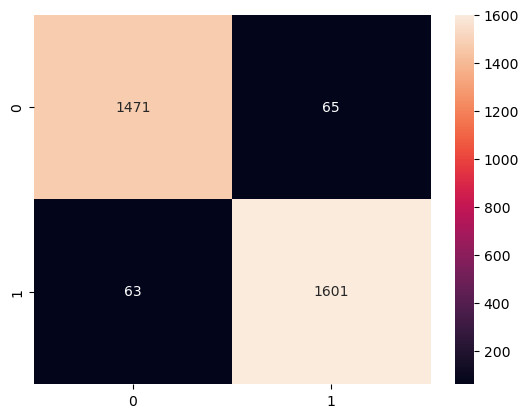

In [16]:
model_with_dropouts = model_with_dropouts.eval()
f1_score_test_with_dropouts = evaluate_model(valid_dl, model_with_dropouts)
print(f'F1_score for test = {f1_score_test_with_dropouts:.3f}') 

# Showing model results (some random titels from the net)

In [18]:
vocab_size = len(vocab)
embed_dim = 400
rnn_hidden_size = 128
fc_hidden_size = 128

# model_testing = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size, p_fc1=0.22, p_fc2=0.48, bidirec=False)
# model_testing.load_state_dict(torch.load('model_with_dropouts'))
model_testing = torch.load('model_with_dropouts')
model_testing.eval()

check_clickbait = ClickbaitClassifier(model_testing, preprocesser, vocab)

some_sentences = ["How I Made $1 Million Last Week From Clicking Here", "Russia-Ukraine war: Germany blocks offer of tanks for Ukraine",
                 "What Happened When I Clicked Here And Asked Her On A Date", "Kylian Mbappe's affectionate gesture to Cristiano that he's never made with Messi",
                  "Germany says it is no longer reliant on Russian energy", "When Students Change Gender Identity, and Parents Don’t Know", 
                 "Artificial intelligence is creating a new colonial world order", "AI research: the unreasonably narrow path and how not to be miserable",
                 "How eating oysters could help protect the coast", "How a middle-class family built a £4m cannabis empire to preserve their lifestyle",
                  "The Meeting Place Cannot Be Changed. Berlin!"
                ]

for example_sentence in some_sentences:
    print(f"'{example_sentence}' is clickbait with probability = {check_clickbait(example_sentence)*100:.2f}%\n")


'How I Made $1 Million Last Week From Clicking Here' is clickbait with probability = 99.96%

'Russia-Ukraine war: Germany blocks offer of tanks for Ukraine' is clickbait with probability = 0.00%

'What Happened When I Clicked Here And Asked Her On A Date' is clickbait with probability = 100.00%

'Kylian Mbappe's affectionate gesture to Cristiano that he's never made with Messi' is clickbait with probability = 100.00%

'Germany says it is no longer reliant on Russian energy' is clickbait with probability = 0.00%

'When Students Change Gender Identity, and Parents Don’t Know' is clickbait with probability = 23.26%

'Artificial intelligence is creating a new colonial world order' is clickbait with probability = 0.00%

'AI research: the unreasonably narrow path and how not to be miserable' is clickbait with probability = 0.28%

'How eating oysters could help protect the coast' is clickbait with probability = 100.00%

'How a middle-class family built a £4m cannabis empire to preserve their 